In [6]:
from metpy.plots import SkewT
from metpy.units import units
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

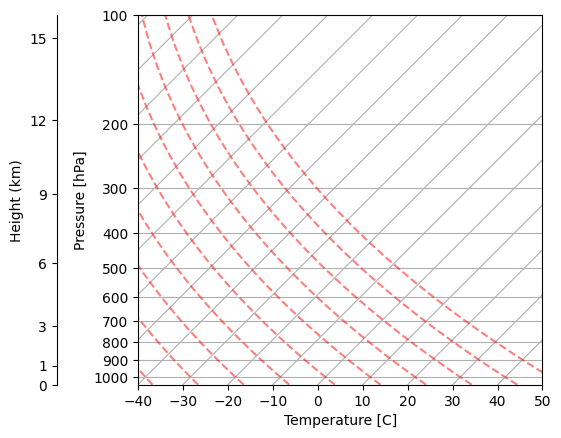

In [8]:
fig = plt.figure()
skew = SkewT(fig, rotation=45)
skew.plot_dry_adiabats()
skew.ax.set_xlabel('Temperature [C]')
skew.ax.set_ylabel('Pressure [hPa]')

secax = skew.ax.secondary_yaxis(-0.2,
    functions=(
        lambda p: mpcalc.pressure_to_height_std(units.Quantity(p, 'hPa')).m_as('km'),
        lambda h: mpcalc.height_to_pressure_std(units.Quantity(h, 'km')).m
    )
)
secax.yaxis.set_major_locator(plt.FixedLocator([0, 1, 3, 6, 9, 12, 15]))
secax.yaxis.set_minor_locator(plt.NullLocator())
secax.yaxis.set_major_formatter(plt.ScalarFormatter())
secax.set_ylabel('Height (km)')
plt.savefig('Figures/skew-t-dry.pdf',bbox_inches='tight')

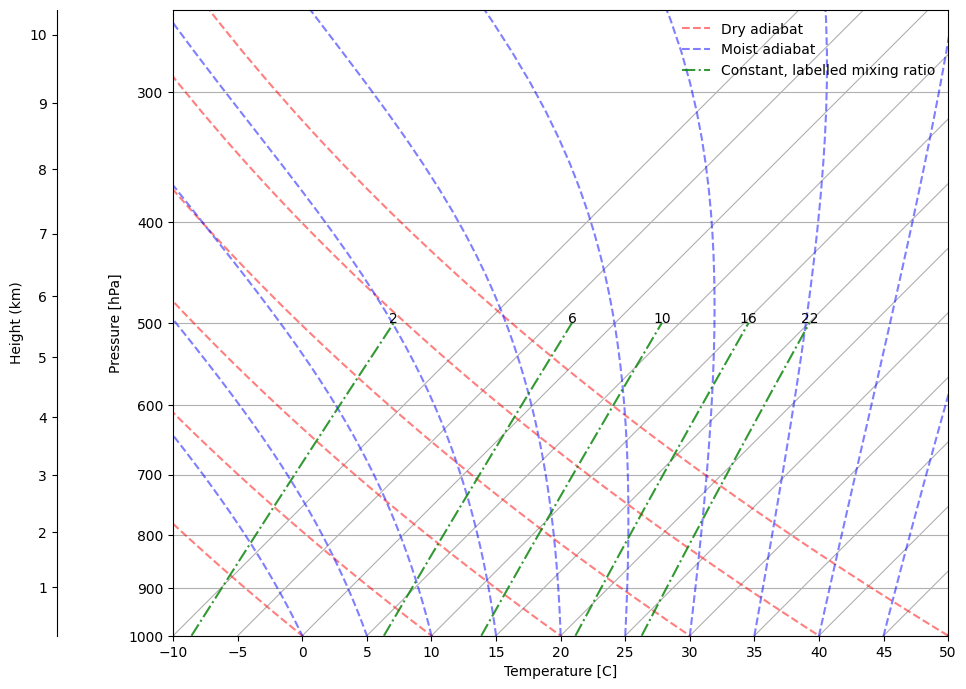

In [10]:
fig = plt.figure()
skew = SkewT(fig, rotation=45)
skew.plot_dry_adiabats(label='Dry adiabat')
skew.plot_moist_adiabats(label='Moist adiabat')
skew.ax.set_xlabel('Temperature [C]')
skew.ax.set_ylabel('Pressure [hPa]')
skew.ax.set_ylim(1000, 250)
skew.ax.set_xlim(-10, 50)

skew.ax.set_xticks(np.arange(-10,55,5))
secax = skew.ax.secondary_yaxis(-0.15,
    functions=(
        lambda p: mpcalc.pressure_to_height_std(units.Quantity(p, 'hPa')).m_as('km'),
        lambda h: mpcalc.height_to_pressure_std(units.Quantity(h, 'km')).m
    )
)
secax.yaxis.set_major_locator(plt.FixedLocator(np.arange(0,11,1)))
secax.yaxis.set_minor_locator(plt.NullLocator())
secax.yaxis.set_major_formatter(plt.ScalarFormatter())
secax.set_ylabel('Height (km)')

w = np.array([0.022, 0.016, 0.01, 0.006, 0.002])[:, None] * units('g/g')
p = units.hPa * np.linspace(1000, 500, 7)
skew.plot_mixing_lines(mixing_ratio=w, pressure=p, color='darkseagreen', linestyle='-.', label='Constant, labelled mixing ratio')

# Label
for val in w.flatten():
    top_p = p[-1]
    dewpt = mpcalc.dewpoint(mpcalc.vapor_pressure(top_p, val))
    skew.ax.text(dewpt, top_p, str(int(val.to('g/kg').m)),
                 horizontalalignment='center')
skew.ax.legend(frameon=False)
fig.set_size_inches(10,10)
plt.savefig('Figures/skew-t-moist-ex.png',bbox_inches='tight')

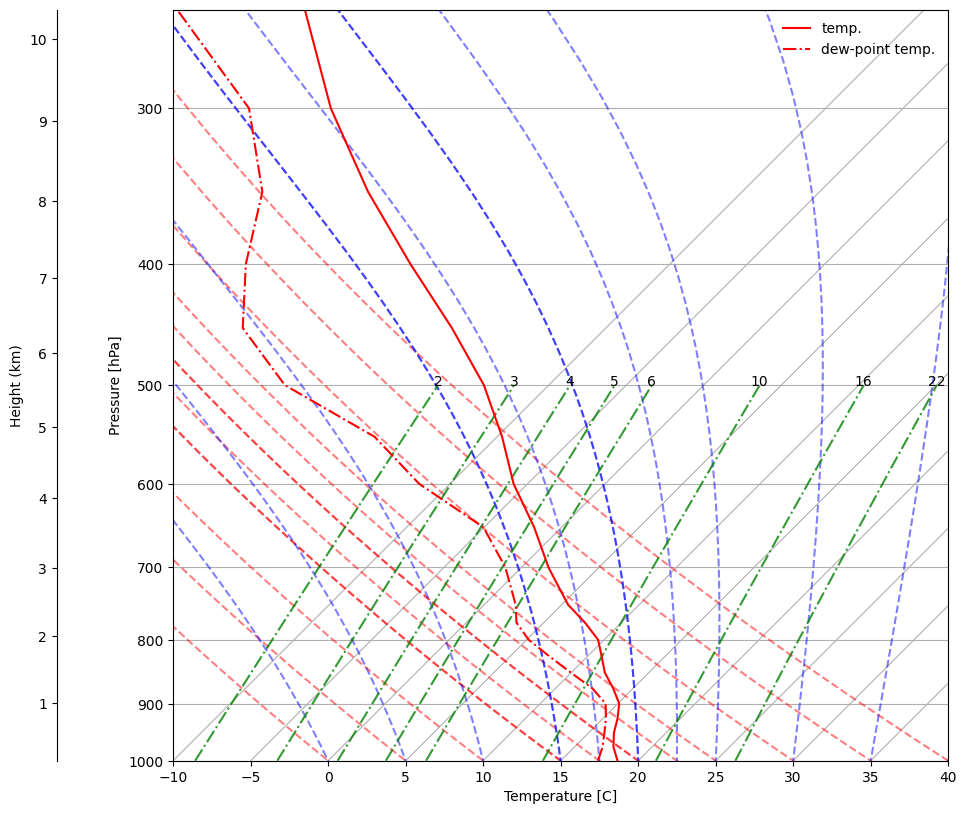

In [105]:
# With a sounding in it
ds = xr.open_dataset('valencia.nc').isel(latitude=0,longitude=0).sel(valid_time='2024-10-29T15:00:00.000000000')

Rd = 287.05
Rv = 461.5 # J/kg/K, gas constant of water
lv_trip = 2500e3 # J/kg, latent heat of vaporisation at the triple point of water
T_trip = 273.15 # K, Temperature for triple point of water at 1000 hPa air pressure
es_trip = 610.94 # Pa, equilibrium vapour pressure at triple point of water

def Tdew(e):
    return (1/T_trip - Rv/lv_trip*np.log(e/es_trip))**(-1)
def e_sq(qs, p):
    return qs * p / (qs * (1-Rd/Rv) + Rd/Rv)

ds['tdew'] = Tdew(e_sq(ds.q, ds.pressure_level*100))

Tad = np.hstack((np.arange(T_trip, T_trip+45, 5), np.arange(T_trip+15, T_trip+25, 2.5)))

fig = plt.figure()
skew = SkewT(fig, rotation=45)
skew.plot_dry_adiabats(Tad*units('K'))
skew.plot_moist_adiabats(Tad*units('K'))
skew.ax.set_xlabel('Temperature [C]')
skew.ax.set_ylabel('Pressure [hPa]')
skew.ax.set_ylim(1000, 250)

skew.ax.set_xticks(np.arange(-10,55,5))
secax = skew.ax.secondary_yaxis(-0.15,
    functions=(
        lambda p: mpcalc.pressure_to_height_std(units.Quantity(p, 'hPa')).m_as('km'),
        lambda h: mpcalc.height_to_pressure_std(units.Quantity(h, 'km')).m
    )
)
secax.yaxis.set_major_locator(plt.FixedLocator(np.arange(0,11,1)))
secax.yaxis.set_minor_locator(plt.NullLocator())
secax.yaxis.set_major_formatter(plt.ScalarFormatter())
secax.set_ylabel('Height (km)')

w = np.array([0.022, 0.016, 0.01, 0.006, 0.005, 0.004, 0.003, 0.002])[:, None] * units('g/g')
p = units.hPa * np.linspace(1000, 500, 7)
skew.plot_mixing_lines(mixing_ratio=w, pressure=p, color='darkseagreen', linestyle='-.')

# Label
for val in w.flatten():
    top_p = p[-1]
    dewpt = mpcalc.dewpoint(mpcalc.vapor_pressure(top_p, val))
    skew.ax.text(dewpt, top_p, str(int(val.to('g/kg').m)),
                 horizontalalignment='center')
fig.set_size_inches(10,10)

# Plot sounding
skew.plot(ds.pressure_level, ds.t-273.15, c='red', label='temp.')
skew.plot(ds.pressure_level, ds.tdew-273.65, c='red', linestyle='-.', label='dew-point temp.')
skew.ax.legend(frameon=False)
skew.ax.set_xlim(-10, 40)
plt.savefig('Figures/skew-t-moist-val.pdf',bbox_inches='tight')

<xarray.Dataset> Size: 92B
Dimensions:         ()
Coordinates:
    number          int64 8B 0
    valid_time      datetime64[ns] 8B 2024-10-29T15:00:00
    pressure_level  float64 8B 700.0
    latitude        float64 8B 39.4
    longitude       float64 8B -0.5
    expver          <U4 16B '0001'
Data variables:
    z               float32 4B 3.044e+04
    r               float32 4B 84.87
    q               float32 4B 0.005238
    t               float32 4B 274.9
    u               float32 4B -16.51
    v               float32 4B 11.91
    w               float32 4B -1.543
    tdew            float64 8B 272.6
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-29T16:27 GRIB to CDM+CF via cfgrib-0.9.1...

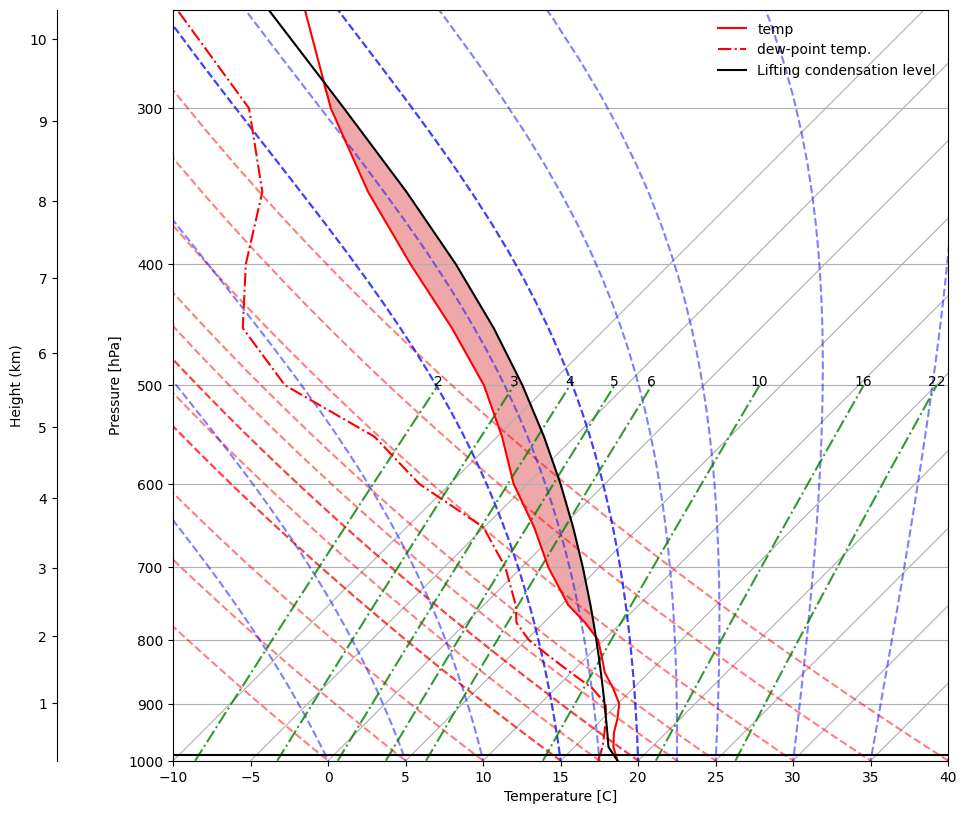

In [112]:
# Answer
prof = mpcalc.parcel_profile(ds.pressure_level*units('hPa'),
                             ds.t[0]*units('K'),
                             ds.tdew[0]*units('K'))


Tad = np.hstack((np.arange(T_trip, T_trip+45, 5), np.arange(T_trip+15, T_trip+25, 2.5)))

fig = plt.figure()
skew = SkewT(fig, rotation=45)
skew.plot_dry_adiabats(Tad*units('K'))
skew.plot_moist_adiabats(Tad*units('K'))
skew.ax.set_xlabel('Temperature [C]')
skew.ax.set_ylabel('Pressure [hPa]')
skew.ax.set_ylim(1000, 250)

skew.ax.set_xticks(np.arange(-10,55,5))
secax = skew.ax.secondary_yaxis(-0.15,
    functions=(
        lambda p: mpcalc.pressure_to_height_std(units.Quantity(p, 'hPa')).m_as('km'),
        lambda h: mpcalc.height_to_pressure_std(units.Quantity(h, 'km')).m
    )
)
secax.yaxis.set_major_locator(plt.FixedLocator(np.arange(0,11,1)))
secax.yaxis.set_minor_locator(plt.NullLocator())
secax.yaxis.set_major_formatter(plt.ScalarFormatter())
secax.set_ylabel('Height (km)')

w = np.array([0.022, 0.016, 0.01, 0.006, 0.005, 0.004, 0.003, 0.002])[:, None] * units('g/g')
p = units.hPa * np.linspace(1000, 500, 7)
skew.plot_mixing_lines(mixing_ratio=w, pressure=p, color='darkseagreen', linestyle='-.')

# Label
for val in w.flatten():
    top_p = p[-1]
    dewpt = mpcalc.dewpoint(mpcalc.vapor_pressure(top_p, val))
    skew.ax.text(dewpt, top_p, str(int(val.to('g/kg').m)),
                 horizontalalignment='center')
# skew.ax.legend(frameon=False)
fig.set_size_inches(10,10)

# Plot sounding
skew.plot(ds.pressure_level, ds.t-273.15, c='red', label='temp')
skew.plot(ds.pressure_level, ds.tdew-273.65, c='red', linestyle='-.', label='dew-point temp.')

# Plot parcel and CAPE
skew.plot(ds.pressure_level, prof.values-273.15, c='k')
skew.shade_cape(ds.pressure_level*units('hPa'),
                (ds.t.values-273.15)*units('degC'),
                (prof.values-273.15)*units('degC'))

skew.ax.set_xlim(-10, 40)
plt.savefig('Figures/skew-t-moist-val-ans.pdf',bbox_inches='tight')

lcl = mpcalc.lcl(ds.pressure_level[0]*units('hPa'),
                 ds.t[0]*units('K'),
                 ds.tdew[0]*units('K'))
skew.ax.axhline(lcl[0], label='Lifting condensation level', c='black')

skew.ax.legend(frameon=False)

ds.sel(pressure_level=700).load()